In [115]:
import meep as mp
import matplotlib.pyplot as plt
import nlopt
import numpy as np
import pickle
from meep_material import lorentzfit
import os

In [116]:
resolution = 200
nfreq = 300
fcen = 1.75
df = 3.3

In [117]:
def Material_fit(Material_data_csv=".",
                 eps_inf_min=1, eps_inf_max=1.2, eps_inf_linespace=1,
                 wl_min=0.39, wl_max=0.71,
                 num_L=3, num_rep=100):
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(Material_data_csv)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf_best, suscepts = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf_best, suscepts

    # --- 2) CSV 로드 및 준비 ---
    data      = np.genfromtxt(Material_data_csv, delimiter=",")
    wl        = data[:, 0]                    # 파장 (μm)
    eps_total = data[:, 1] + 1j*data[:, 2]     # permittivity

    mask     = (wl >= wl_min) & (wl <= wl_max)
    wl_red   = wl[mask]
    freqs_red = 1.0 / wl_red
    eps_total_red = eps_total[mask]
    eps_fit_target_raw = eps_total_red        # eps_inf 뺄 전 원본

    # --- 3) 내부 피팅 함수 ---
    def fit_for_eps_inf(eps_inf):
        eps_fit_target = eps_fit_target_raw - eps_inf
        best_err = np.inf
        best_p   = None
        for _ in range(num_rep):
            p0 = []
            for _ in range(num_L):
                # 초기 파라미터: σ∈[1,100], ω∈[1/λ_max,1/λ_min], γ∈[1e-2,1]
                sigma0 = 10**np.random.uniform(0, 2)
                omega0 = np.random.uniform(1.0/wl_max, 1.0/wl_min)
                gamma0 = 10**np.random.uniform(-2, 0)
                p0.extend([sigma0, omega0, gamma0])
            p_opt, err = lorentzfit(p0, freqs_red, eps_fit_target,
                                    nlopt.LD_MMA, 1e-25, 200000)
            if err < best_err:
                best_err = err
                best_p   = p_opt
        return best_err, best_p

    # --- 4) eps_inf 스윕 및 최적화 ---
    eps_inf_vals = np.linspace(eps_inf_min, eps_inf_max, eps_inf_linespace)
    results = []
    for e_inf in eps_inf_vals:
        err, p_opt = fit_for_eps_inf(e_inf)
        results.append((e_inf, err, p_opt))

    eps_inf_best, err_best, p_opt_best = min(results, key=lambda x: x[1])
    print("Best eps_inf:", eps_inf_best, "error:", err_best)

    # --- 5) susceptibilities 생성 ---
    suscepts = []
    for j in range(num_L):
        ω = p_opt_best[3*j + 1]
        γ = p_opt_best[3*j + 2]
        if abs(ω) < 1e-8:
            σ = p_opt_best[3*j + 0]
            suscepts.append(mp.DrudeSusceptibility(frequency=1.0, gamma=γ, sigma=σ))
        else:
            σ = p_opt_best[3*j + 0] / ω**2
            suscepts.append(mp.LorentzianSusceptibility(frequency=ω, gamma=γ, sigma=σ))

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf_best, suscepts), f)
    print(f"Saved fit to pickle: {pickle_path}")

    return eps_inf_best, suscepts

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/lumerical_sio2_eps.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/lumerical_al_eps.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/lumerical_aNDP_eps.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/meep_material.py:20: RuntimeWarning: invalid value encountered in divide
  y = y + A_n / (np.square(x_n) - np.square(x) - 1j * x * g_n)  # Lorentzian 함수 계산
/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/meep_material.py:34: RuntimeWarning: invalid value encountered in divide
  d = 1 / (np.square(x_n) - np.square(x) - 1j * x * g_n)  # Lorentzian 함수의 도함수


Best eps_inf: 1.0 error: 0.0002953759906049027
Saved fit to pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/lumerical_sio2_eps_fit.pkl


KeyboardInterrupt: 

In [118]:
import numpy as np
import meep as mp
import nlopt
from typing import Tuple

# lorentzfit 함수는 이미 정의되어 있어야 함 (여기선 너가 가지고 있다고 가정함)

def fit_material_from_csv(
    csv_path: str,
    wl_range_nm = [0.38, 0.72],
    eps_inf: float = 1.1,
    num_lorentzians: int = 3,
    num_repeat: int = 100,
    opt_tol: float = 1e-25,
    maxeval: int = 50000,
) -> mp.Medium:
    # --- 0) 피클 경로 설정 ---
    base, _ = os.path.splitext(csv_path)
    pickle_path = base + "_fit.pkl"

    # --- 1) 피클이 있으면 로드 후 반환 ---
    if os.path.exists(pickle_path):
        with open(pickle_path, "rb") as f:
            eps_inf, E_sus, freq_range = pickle.load(f)
        print(f"Loaded fit from pickle: {pickle_path}")
        return eps_inf, E_sus, freq_range
    
    # 데이터 불러오기
    mydata = np.genfromtxt(csv_path, delimiter=",")
    wl = mydata[:, 0]  # nm
    n_complex = mydata[:, 1] + 1j * mydata[:, 2]
    eps_data = np.square(n_complex) - eps_inf  # 유전율에서 eps_inf 보정

    # 파장 범위 필터링
    wl_min, wl_max = wl_range_nm
    idx_start = np.where(wl > wl_min)[0][0]
    idx_end = np.where(wl < wl_max)[0][-1] + 1
    wl_reduced = wl[idx_start:idx_end]
    eps_reduced = eps_data[idx_start:idx_end]
    freqs_reduced = 1 / wl_reduced  # nm → 1/μm (Meep 단위)

    # 최적화 반복
    ps = np.zeros((num_repeat, 3 * num_lorentzians))
    mins = np.zeros(num_repeat)

    for m in range(num_repeat):
        p_rand = [10 ** (np.random.random()) for _ in range(3 * num_lorentzians)]
        ps[m, :], mins[m] = lorentzfit(
            p_rand, freqs_reduced, eps_reduced, nlopt.LD_MMA, opt_tol, maxeval
        )
        print(f"[{m:2d}] RMS error: {mins[m]:.6e} — params: {ps[m, :]}")

    # 최적 피팅 결과 선택
    idx_opt = np.argmin(mins)
    popt = ps[idx_opt, :]
    print(f"\n>> Best fit RMS error = {mins[idx_opt]:.6e}")
    print(f">> Optimal parameters = {popt}")

    # mp.Medium 구성
    E_sus = []

    for i in range(num_lorentzians):
        sigma = popt[3 * i + 0]
        freq = popt[3 * i + 1]
        gamma = popt[3 * i + 2]

        if freq == 0:
            # Drude 항
            E_sus.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            # Lorentz 항
            sigma_adj = sigma / freq**2
            E_sus.append(mp.LorentzianSusceptibility(frequency=freq, gamma=gamma, sigma=sigma_adj))

    # 유효 주파수 범위 설정
    freq_min = 1 / wl_max
    freq_max = 1 / wl_min
    freq_range = mp.FreqRange(min=freq_min, max=freq_max)

    # --- 6) 결과를 피클로 저장 ---
    with open(pickle_path, "wb") as f:
        pickle.dump((eps_inf, E_sus, freq_range), f)

    return eps_inf, E_sus, freq_range

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data.csv"

In [119]:
eps_inf_sio2, suscept_sio2, freq_sio2 = fit_material_from_csv(csv_path=sio2_data_path, num_lorentzians=2)
eps_inf_al, suscept_al, freq_al = fit_material_from_csv(csv_path=al_data_path, num_lorentzians=7)
eps_inf_andp, suscept_andp, freq_andp = fit_material_from_csv(csv_path=andp_data_path, num_lorentzians=5)

Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/SiO2/Material data/sio2_material_data_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/Al/Material data/al_material_data_fit.pkl
Loaded fit from pickle: /home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/New fitting/New fitting data/aNDP/Material data/aNDP_material_data_fit.pkl


In [120]:
sio2 =  mp.Medium(epsilon = 1.1,   E_susceptibilities = suscept_sio2, valid_freq_range=freq_sio2) # SiO2 ,
andp =  mp.Medium(epsilon = 1.1,   E_susceptibilities = suscept_andp, valid_freq_range=freq_andp) # aNDP ,
Al  =   mp.Medium(epsilon = 1.1,     E_susceptibilities = suscept_al, valid_freq_range=freq_al)

In [121]:
### ----- Refractive index ----- ###,
# Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 ,
# aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP ,
# Cathode = mp.Medium(epsilon = eps_inf_al, E_susceptibilities = suscept_al)

Glass = sio2
aNDP = andp
Cathode = Al

# Cathode = mp.perfect_electric_conductor,
CoverLayer_index = 1.9
ITO_m_index = 1.8
Alq3_index = 1.68

CoverLayer = mp.Medium(epsilon=CoverLayer_index**2) # SiN ,
ITO_m = mp.Medium(epsilon=ITO_m_index**2) 
Alq3 = mp.Medium(index = Alq3_index) 
Air = mp.Medium(index=1.0) # 공기,

Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

Absorber_layer = 0.5

boundary_layers = [
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.Low),  # 좌측 Absorber,
    mp.Absorber(thickness=Absorber_layer, direction=mp.X, side=mp.High), # 우측 Absorber,
    mp.Absorber(thickness=Absorber_layer, direction=mp.Y, side=mp.High), # 상단 Absorber,
    mp.Absorber(thickness=0.25, direction=mp.Y, side=mp.Low), # 상단 Absorber,

]

Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [122]:
cell_size = mp.Vector3(31, 2, 0)

geometry_fitting_Al = [
        # Cathode (하단)
        mp.Block(
            center=Cathode_center,
            size=mp.Vector3(mp.inf, Cathode_layer, 0),
            material=Cathode
        ),
        # Alq3
        mp.Block(
            center=Alq3_center,
            size=mp.Vector3(mp.inf, Alq3_layer, 0),
            material=Alq3
        ),
        # aNDP
        mp.Block(
            center=aNDP_center,
            size=mp.Vector3(mp.inf, aNDP_layer, 0),
            material=aNDP
        ),
        # ITO
        mp.Block(
            center=ITO_center,
            size=mp.Vector3(mp.inf, ITO_layer, 0),
            material=ITO_m
        ),
        # Cover layer
        mp.Block(
            center=Cover_center,
            size=mp.Vector3(mp.inf, Cover_layer, 0),
            material=CoverLayer
        ),
        # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
        mp.Block(
            center=Glass_center,
            size=mp.Vector3(mp.inf, Glass_layer, 0),
            material=Glass
        )
]

source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
        src=mp.GaussianSource(frequency=fcen, fwidth=df),
        component=mp.Ex,
        center=source_center,
        size=mp.Vector3(0,0,0),
        
        # amplitude = 0.1
)]

In [123]:
# === 시뮬레이션 설정 === #
sim_fitting = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry_fitting_Al[5:6],
    default_material=mp.Medium(index = 1),
    sources=sources,
    resolution=resolution,
    eps_averaging=True,
    extra_materials=[Cathode, Alq3, aNDP, CoverLayer, Glass]
)

     block, center = (0,0.315,0)
          size (1e+20,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)


/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


<Axes: xlabel='X', ylabel='Y'>

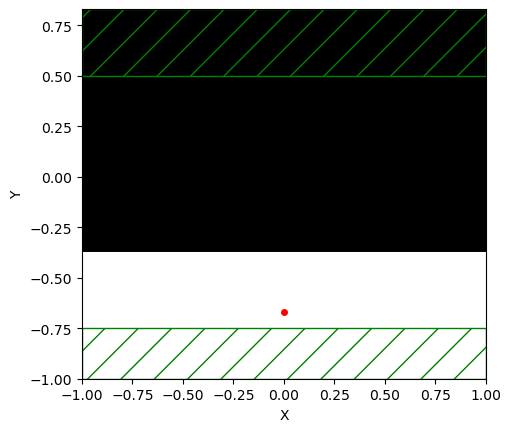

In [124]:
sim_fitting.plot2D(output_plane = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 3, 0)))

In [125]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

box_power_fitting = sim_fitting.add_flux(
    fcen_monitor, df_monitor, nfreq,
    mp.FluxRegion(center=source_center - mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(offset, 0, 0),
                  size=mp.Vector3(0, flux_size),
                  # direction=mp.X
                  ),
    mp.FluxRegion(center=source_center - mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y, 
                  weight=-1),
    mp.FluxRegion(center=source_center + mp.Vector3(0, offset, 0),
                  size=mp.Vector3(flux_size, 0),
                  # direction=mp.Y
                  )
)

# sim_fitting_Al.run(until_after_sources = mp.stop_when_fields_decayed(1e-5, mp.Ex, source_center, 0), until = 200)

sim_fitting.run(until = 20)
net_power_fitting = mp.get_fluxes(box_power_fitting)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000161886 s
Working in 2D dimensions.
Computational cell is 31 x 2 x 0 with resolution 200
     block, center = (0,0.315,0)
          size (1e+20,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1.1,1.1,1.1)
time for set_epsilon = 2.31658 s
time for set_conductivity = 0.071326 s
time for set_conductivity = 0.0717289 s
time for set_conductivity = 0.110612 s
time for set_conductivity = 0.109905 s
time for set_conductivity = 0.109594 s
time for set_conductivity = 0.112574 s
lorentzian susceptibility: frequency=3.87738, gamma=0
lorentzian susceptibility: frequency=2.56476, gamma=0.41218
lorentzian susceptibility: frequency=2.54182, gamma=0.00966449
lorentzian susceptibility: frequency=2.63096, gamma=0.00683744
lorentzian susceptibility: frequency=3.70296, gamma=0
lorentzian susceptibility: frequency=0.666731, gamma=0
lorentzian susceptibility: frequency=0.524445, gamma=

/home/min/miniconda3/envs/mp/lib/python3.11/site-packages/meep/simulation.py:1660: RuntimeWarning: Note: your sources include frequencies outside the range of validity of the material models. This is fine as long as you eventually only look at outputs (fluxes, resonant modes, etc.) at valid frequencies.
  warnings.warn(warn_src, RuntimeWarning)


Meep progress: 0.2575/20.0 = 1.3% done in 4.0s, 308.0s to go
on time step 103 (time=0.2575), 0.0390043 s/step
Meep progress: 0.535/20.0 = 2.7% done in 8.0s, 292.2s to go
on time step 214 (time=0.535), 0.0361643 s/step
Meep progress: 0.7275/20.0 = 3.6% done in 12.1s, 321.5s to go
on time step 291 (time=0.7275), 0.0532866 s/step
Meep progress: 1.01/20.0 = 5.0% done in 16.1s, 303.4s to go
on time step 404 (time=1.01), 0.0353994 s/step
Meep progress: 1.3025/20.0 = 6.5% done in 20.2s, 289.3s to go
on time step 521 (time=1.3025), 0.0343502 s/step
Meep progress: 1.6025/20.0 = 8.0% done in 24.2s, 277.5s to go
on time step 641 (time=1.6025), 0.033453 s/step
Meep progress: 1.9025/20.0 = 9.5% done in 28.2s, 268.2s to go
on time step 761 (time=1.9025), 0.0335111 s/step
Meep progress: 2.2175000000000002/20.0 = 11.1% done in 32.2s, 258.3s to go
on time step 887 (time=2.2175), 0.0318522 s/step
Meep progress: 2.5225/20.0 = 12.6% done in 36.2s, 251.0s to go
on time step 1009 (time=2.5225), 0.0329803 s/

### resolution 1000 - air(sourcepower)

In [126]:
from src_resolution import sourcepower

src_wavelengths, src_power = sourcepower(200)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 2D dimensions.
Computational cell is 3 x 3 x 0 with resolution 200
time for set_epsilon = 0.175585 s
-----------
Meep progress: 10.4625/20.0 = 52.3% done in 4.0s, 3.6s to go
on time step 4185 (time=10.4625), 0.000956006 s/step
run 0 finished at t = 20.0 (8000 timesteps)
CSV 파일 저장 완료: sourcepower_res200.csv


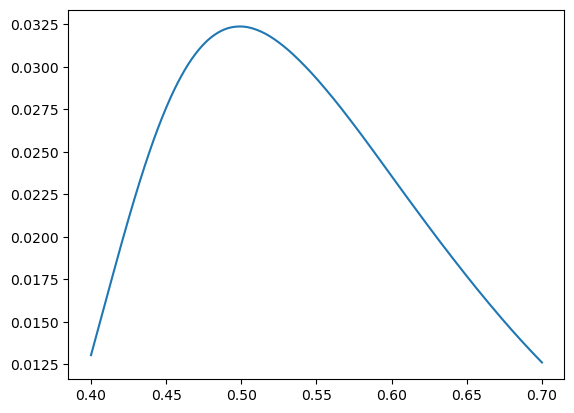

In [127]:
plt.plot(src_wavelengths, net_power_fitting)

In [129]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/200_sio2.txt")

# CSV 파일 불러오기
lumerical_data = np.genfromtxt(csv_path, delimiter=",")

lumerical = lumerical_data[:, 1]

In [ ]:
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/RESOLUTION/dp_100.txt")

# CSV 파일 불러오기
lumerical_data_com = np.genfromtxt(csv_path, delimiter=",")

lumerical_com = lumerical_data_com[:, 1]

In [ ]:
# lumerical data import
import numpy as np
from pathlib import Path

csv_path = Path("/home/min/EIDL/Tool/Meep/LGD/Meep code/OLED structure/Layer by Layer check/sourcepower_1000.csv")

# CSV 파일 불러오기
air_1000_data = np.genfromtxt(csv_path, delimiter=",", skip_header=1)

air_1000 = air_1000_data[:, 1]

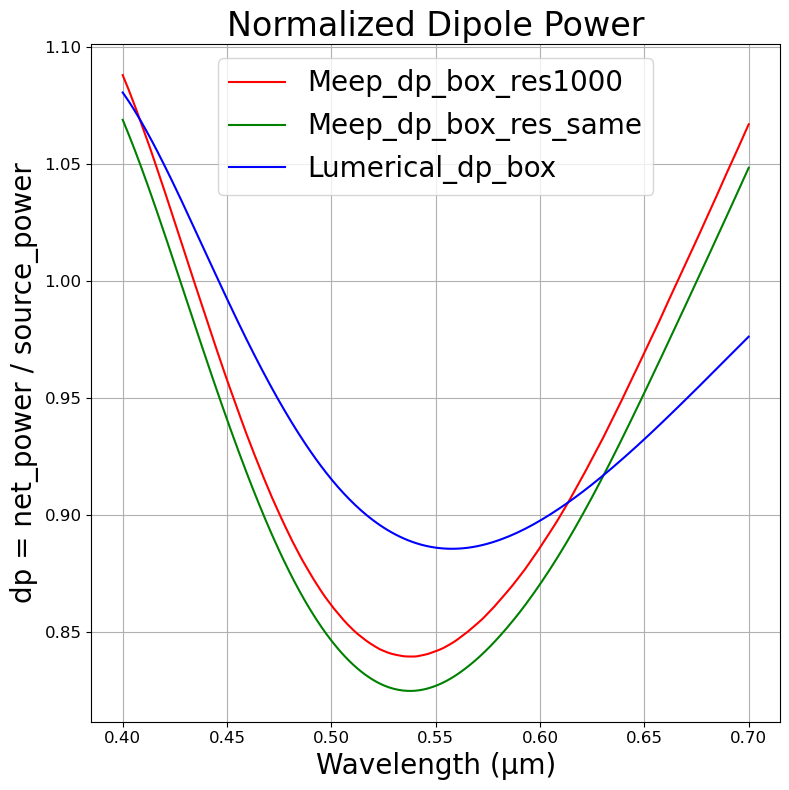

In [130]:
# dp_box / sourcepower 정규화
dp_fitting = np.array(net_power_fitting) / air_1000 
dp_fitting_100 = np.array(net_power_fitting) / src_power

wavelengths = 1 / np.array(mp.get_flux_freqs(box_power_fitting))

plt.figure(figsize=(8, 8))

# plot 순서
plt.plot(wavelengths, dp_fitting, label='Meep_dp_box_res1000', color='red')
plt.plot(wavelengths, dp_fitting_100, label='Meep_dp_box_res_same', color='green')
plt.plot(wavelengths, lumerical, label='Lumerical_dp_box', color='blue')
# plt.plot(wavelengths, lumerical_com, label='Lumerical_dp_box_', color='purple')

# plt.plot(wavelength_sliced_nofunc, Al_power_sliced_nofunc, label='Lumerical dp', color='green')


# 축 레이블 (굵게 + 크기 조정)
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("dp = net_power / source_power", fontsize=20)

# 제목 (굵게 + 크기 조정)
plt.title("Normalized Dipole Power", fontsize=24)

# 눈금 폰트 크기 조정
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 범례 (폰트 크기 조정 + 굵게)
plt.legend(fontsize=20, frameon=True,)

# 기타 설정
plt.grid(True)
plt.tight_layout()
# plt.ylim([0, 1.5])
# plt.xlim([0.4, 0.7])
plt.show()

In [ ]:
# === Relative Error 계산 === #
relative_error = np.abs((dp_fitting_al - lumerical) / lumerical)* 100

# relative_error_nofunc = np.abs((Al_power_sliced_nofunc - dp_fitting_al) / dp_fitting_al)* 100


# === Relative Error 플롯 === #
plt.figure(figsize=(8, 8))
plt.plot(wavelengths, relative_error, label='Relative Error', color='purple')
# plt.plot(wavelengths, relative_error_nofunc, label='Relative Error dp_box', color='cyan')


# 축 레이블
plt.xlabel("Wavelength (μm)", fontsize=20)
plt.ylabel("Relative Error (%)", fontsize=20)

# 제목
plt.title("Relative Error: Lumerical vs Meep (Al)", fontsize=24)

# 눈금, 범례
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xlim([0.4, 0.7])
plt.show()


NameError: name 'dp_fitting_al' is not defined